In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
import seaborn as sns
sns.set_style("whitegrid")
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

## Logistic Regression vs. Linear Regression

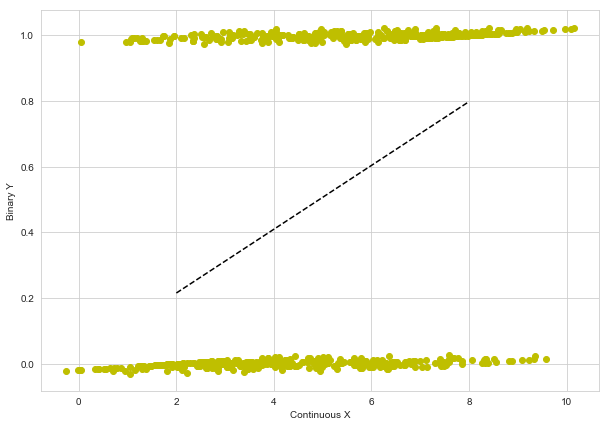

In [3]:
# Set the random seed so that the 'random' data is the same each same each time the code is run.
np.random.seed(seed=456613)

# Create some data
df = pd.DataFrame()

for probs in list(range(2, 9)):
    tmp = pd.DataFrame({
        'y': np.random.binomial(1, probs / 10, size = (1,100))[0],
        'x': probs})
    df = df.append(tmp)

# Continuous predictor
x = df['x']

# Binary outcome
bin_y = df['y']

# Calculate linear regression for x and bin_y
fit = np.polyfit(x, bin_y, 1)

# Work as a function to return the predicted value of y
fit_fn = np.poly1d(fit)

# Add a little 'noise' to the data for graphing purposes
jitter = np.random.randn(700)

# Display our results
plt.figure(figsize=(10,7))
plt.plot(x + jitter, bin_y + jitter / 100, 'yo', x, fit_fn(x), '--k')
plt.xlabel('Continuous X')
plt.ylabel('Binary Y')
plt.show()

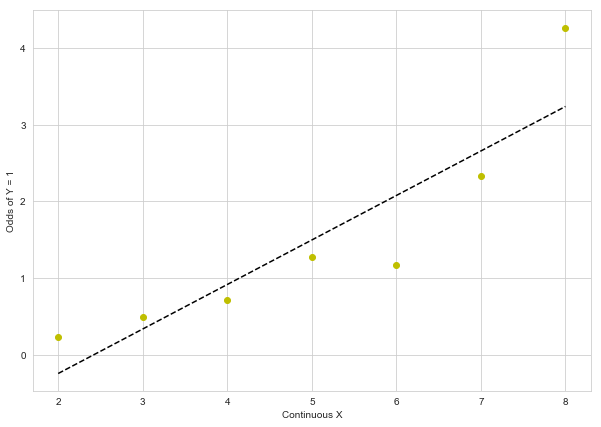

In [4]:
# Unique values in x
xvals = x.unique()

# Calculate and store the odds
yodds = []
for xi in xvals:
    y1_ct = bin_y[x == xi].sum() # The number of trials y = 1
    y0_ct = len(bin_y[x == xi]) - y1_ct # The number of trials y = 0
    yodds.append(y1_ct / y0_ct) # Odds of getting y = 1 for xi

# Calculate linear regression for x and yodds
fit = np.polyfit(xvals, yodds, 1)

# Work as a function to return the predicted value of yodds
fit_fn = np.poly1d(fit)

# Display our work
plt.figure(figsize=(10,7))
plt.plot(xvals, yodds, 'yo', xvals, fit_fn(xvals), '--k')
plt.xlabel('Continuous X')
plt.ylabel('Odds of Y = 1')
plt.show()

## Logarithms to the Rescue

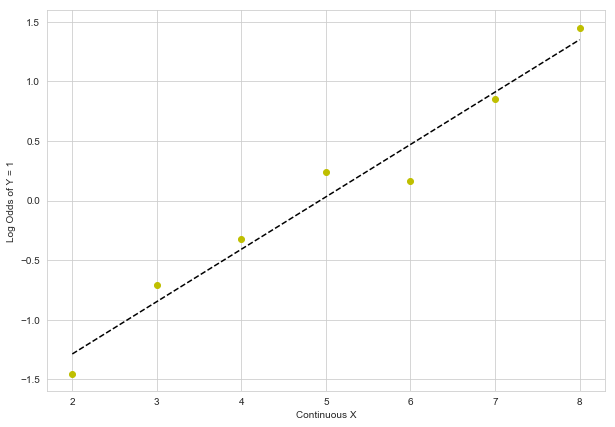

In [5]:
# Natural log of the odds 
ln_yodds = np.log(yodds)

# Calculate linear regression for x and yodds
fit = np.polyfit(xvals, ln_yodds, 1)

# Works as a function to return the predicted value of yodds
fit_fn = np.poly1d(fit)

# Display
plt.figure(figsize=(10,7))
plt.plot(xvals, ln_yodds, 'yo', xvals, fit_fn(xvals), '--k')
plt.xlabel('Continuous X')
plt.ylabel('Log Odds of Y = 1')
plt.show()

## Think Like a Data Scientist

The ability to clearly communicate results like this is a key skill of the data scientist. Your data and models are worthless unless people understand them well enough to act.

Imagine you ran a binary logistic regression predicting likelihood of developing a hearing problem, using age in years and male (0=female, 1=male) as predictors. Your final model looks like this:

_logit(HasHearingProblem) = −1 + 0.02 ∗ age + 1 ∗ male_
 
Write out a description of the effects that age and gender have on the odds of developing hearing problems in terms a layperson could understand. Include estimates for the odds of hearing problems in a 95 year old woman and a 50 year old man. Discuss your interpretation with your mentor.

___Woman 95:___ _8.99 times more likely to have hearing problems_<br>
___Man   50:___ _2.72 times more likely to have hearing problems

## Fitting a Binary Logistic Model using Statsmodel

   admit  gre   gpa  rank
0      0  380  3.61     3
1      1  660  3.67     3
2      1  800  4.00     1
3      1  640  3.19     4
4      0  520  2.93     4


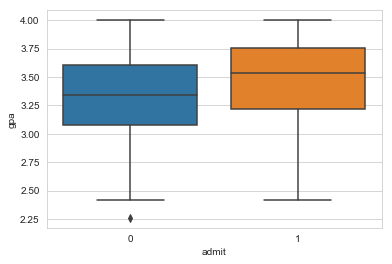

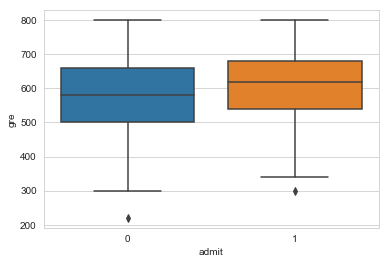

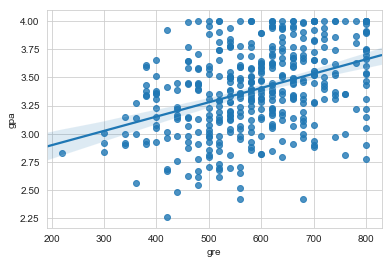

In [6]:
# Read in the data
df = pd.read_csv("https://www.dropbox.com/s/qhf0ocdqb3gh7ni/logistic_regression.csv?dl=1")

# Take a peek
print(df.head())

# Bivariate relationships of predictors to admissions outcome.
sns.boxplot(x = "admit", y = "gpa", data = df)
plt.show()

sns.boxplot(x = "admit", y = "gre", data = df)
plt.show()

# Relationship between predictors
sns.regplot(x = 'gre', y = 'gpa', data = df)
plt.show()

In [8]:
# Declare predictors
X_statsmod = df[['gre', 'gpa']]

# The Statsmodels formulation requires a column with constant value 1 that will act as the intercept
X_statsmod['intercept'] = 1

# Declare and fit the model
logit = sm.Logit(df['admit'], X_statsmod)
result = logit.fit()

# Lots of information about the model and its coefficients, but the accuracy rate for predictions is missing.
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.600430
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                  admit   No. Observations:                  400
Model:                          Logit   Df Residuals:                      397
Method:                           MLE   Df Model:                            2
Date:                Tue, 15 Jan 2019   Pseudo R-squ.:                 0.03927
Time:                        17:38:15   Log-Likelihood:                -240.17
converged:                       True   LL-Null:                       -249.99
                                        LLR p-value:                 5.456e-05
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
gre            0.0027      0.001      2.544      0.011       0.001       0.005
gpa            0.7547      0.

In [11]:
# Calculate accuracy. First, get probability that each row will be admitted.
pred_statsmod = result.predict(X_statsmod)

# Code admission as 1 if prbability is greater than 5%
pred_y_statsmod = np.where(pred_statsmod < 0.5, 0, 1)

# Accuracy table
table = pd.crosstab(df['admit'], pred_y_statsmod)

print('Accuracy by Admission Status')
print(table)
print('\nPercentage Accuracy')
print((table.iloc[0,0] + table.iloc[1,1]) / (table.sum().sum()))

Accuracy by Admission Status
col_0    0   1
admit         
0      263  10
1      118   9

Percentage Accuracy
0.68


## Fitting a Binary Logistic Model using SKLearn

In [18]:
# Declare a logistic regression classifier
# Parameter regularization coefficient C as described in the curriculum
lr = LogisticRegression(C=1e9)
y = df['admit']
X = df[['gpa', 'gre']]

# Fit the model
fit = lr.fit(X, y)

# Display
print('Coefficients')
print(fit.coef_)
print(fit.intercept_)
pred_y_sklearn = lr.predict(X)

print('\nAccuracy by Admission Status')
print(pd.crosstab(pred_y_sklearn, y))

print('\nPercentage Accuracy')
print(round((lr.score(X, y)) * 100, 0), '%')

Coefficients
[[0.74747563 0.00267019]]
[-4.91157158]

Accuracy by Admission Status
admit    0    1
row_0          
0      263  118
1       10    9

Percentage Accuracy
68.0 %


## Challenge: Optimize the Model

In [19]:
# Declare a logistic regression classifier
# Parameter regularization coefficient C as described in the curriculum
lr = LogisticRegression(C=1e5)
y = df['admit']
X = df[['gpa', 'gre', 'rank']]

# Fit the model
fit = lr.fit(X, y)

# Display
print('Coefficients')
print(fit.coef_)
print(fit.intercept_)
pred_y_sklearn = lr.predict(X)

print('\nAccuracy by Admission Status')
print(pd.crosstab(pred_y_sklearn, y))

print('\nPercentage Accuracy')
print(round((lr.score(X, y)) * 100, 0), '%')

Coefficients
[[ 0.7702094   0.00227441 -0.55872894]]
[-3.4167784]

Accuracy by Admission Status
admit    0   1
row_0         
0      253  98
1       20  29

Percentage Accuracy
70.0 %
